In [ ]:
import pandas as pd
df =  pd.read_csv(r"C:\Users\Carlo\Desktop\simulador_empresarial\ProjecteData\Equip_16\Data\banca_22.09_dataset.csv")

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
#verificación nulos
df.isnull().any().any()

In [ ]:
# suma de nulos por columna
df.isnull().sum()

In [ ]:
# Para ver duplicados

df.duplicated()
# df = df.drop_duplicates(subset=['Product', 'Location']) (para eliminar duplicados concretos en función de una columna)
df = df.drop_duplicates()

In [ ]:
filas_con_nulos = df[df.isnull().any(axis=1)]
filas_con_nulos

In [ ]:
def clase_edad(x):
    if x < 18:
        return "unknown"
    elif x >= 18 and x <=24: 
        return '18-24'
    elif  x >= 25 and x <= 34:
        return '25-34'
    elif  x >= 35 and x <= 44:
        return '35-44'
    elif  x >= 45 and x <= 54:
        return '45-54'
    elif  x >= 55 and x <= 64:
        return '55-64'
    else:
        return '65+' #Como no hay edades inferiores a 18 no va dar problemae

df['Clase de edad'] = df['age'].apply(clase_edad)

In [ ]:
def perfil(x):
    if x == "unknown":
        return "unknown"
    elif x == '18-24': 
        return "Gen Z & Boomers"
    elif  x == '25-34':
        return 'Millenials'
    elif  x == '35-44':
        return 'Adultxs'
    elif  x == '45-54':
        return 'Divorciadxs'
    elif  x == '55-64':
        return "Gen Z & Boomers"
    elif x == '65+':
        return "Gen Z & Boomers" #Como no hay edades inferiores a 18 no va dar problemae

df["Perfil"] = df['Clase de edad'].apply(perfil)
df # Para visualizar la tabla generada

In [ ]:
# -------------------------
# Función para imputar nulos
# -------------------------
def imputar(row):
    # 1) age
    if pd.isna(row["age"]):
        if row["job"] == "retired":
            row["age"] = 65
        elif row["job"] == "management":
            row["age"] = 45
        elif row["job"] == "technician":
            row["age"] = 35
        else:
            row["age"] = 40
    
    # 2) marital
    if pd.isna(row["marital"]):
        row["marital"] = "single" if row["age"] < 32 else "married"
    
    # 3) education
    if pd.isna(row["education"]):
        if row["job"] in ["management", "technician"]:
            row["education"] = "tertiary"
        elif row["job"] == "retired":
            row["education"] = "secondary"
        else:
            row["education"] = "primary"
    
    # 4) job
    if pd.isna(row["job"]):
        if row["education"] == "tertiary":
            row["job"] = "management"
        elif row["education"] == "secondary":
            row["job"] = "technician"
        else:
            row["job"] = "unknown"
    # 5) housing
    if pd.isna(row["housing"]):
        if row["Clase de edad"] == "25-34":
            row["housing"] = "yes"
        else:
            row["housing"] = "no"
    return row
# Aplicamos la función
df = df.apply(imputar, axis=1)
df.isnull().sum()

In [ ]:
#sustitución de valores nulos

df["marital"] = df["marital"].fillna("unknown")
df["education"] = df["education"].fillna("unknown")

In [ ]:
total_contactos = df["campaign"].sum()

In [ ]:

total_convertidos = (df["deposit"]== "yes").sum()


In [ ]:
total_convertidos

In [ ]:
tasa_exito = total_convertidos / total_contactos * 100
tasa_exito = round(tasa_exito,2)

In [ ]:

def tasa_exito_por_categoria(df, columna):
    resumen = (
        df.groupby(columna)["deposit"]
        .apply(lambda x: (x == "yes").mean() * 100)
        .reset_index(name="tasa_exito")
        .sort_values("tasa_exito", ascending=False)
    )
    return resumen

# Ejemplo: tasa de éxito por trabajo
tasa_job = tasa_exito_por_categoria(df, "job")
print(tasa_job)

# Ejemplo: tasa de éxito por nivel educativo
tasa_edu = tasa_exito_por_categoria(df, "education")
print(tasa_edu)

C:\Users\Carlo\AppData\Local\Temp\ipykernel_29080\1696997423.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


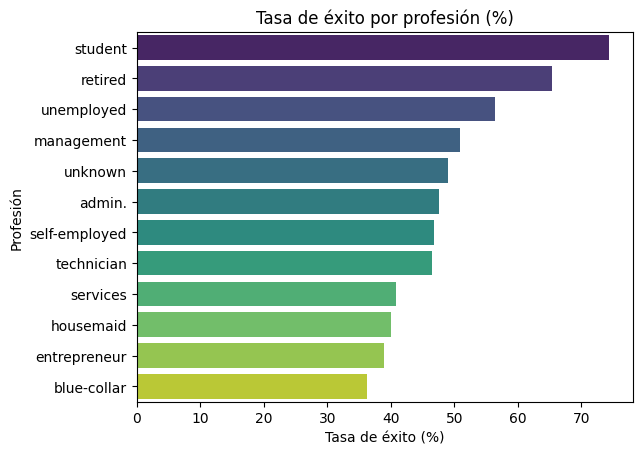

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(
    data=tasa_job,
    x="tasa_exito",
    y="job",
    palette="viridis"
)
plt.title("Tasa de éxito por profesión (%)")
plt.xlabel("Tasa de éxito (%)")
plt.ylabel("Profesión")
plt.show()

In [25]:
import pandas as pd
from scipy.stats import chi2_contingency

# Tabla de contingencia
tabla = pd.crosstab(df["contact"], df["deposit"])
chi2, p, dof, expected = chi2_contingency(tabla)

print("Chi-cuadrado:", chi2)
print("p-valor:", p)

Chi-cuadrado: 1073.9294593297593
p-valor: 6.297684938138114e-234


In [26]:
import statsmodels.api as sm

# Éxitos y totales por grupo
exitos = [
    sum((df["contact"] == "telephone") & (df["deposit"] == "yes")),
    sum((df["contact"] == "cellular") & (df["deposit"] == "yes"))
]
totales = [
    sum(df["contact"] == "telephone"),
    sum(df["contact"] == "cellular")
]

z, p = sm.stats.proportions_ztest(exitos, totales)
print("Z:", z)
print("p-valor:", p)

Z: -2.1489622706306317
p-valor: 0.03163739088508277


In [27]:
import numpy as np
import statsmodels.api as sm

# Éxitos y totales por grupo
exitos = np.array([
    sum((df["contact"] == "telephone") & (df["deposit"] == "yes")),
    sum((df["contact"] == "cellular") & (df["deposit"] == "yes"))
])
totales = np.array([
    sum(df["contact"] == "telephone"),
    sum(df["contact"] == "cellular")
])

# Proporciones
prop = exitos / totales

# Diferencia de proporciones
diff = prop[0] - prop[1]

# Intervalo de confianza al 95%
cm = sm.stats.CompareMeans(
    sm.stats.DescrStatsW([1]*exitos[0] + [0]*(totales[0]-exitos[0])),
    sm.stats.DescrStatsW([1]*exitos[1] + [0]*(totales[1]-exitos[1]))
)
ic_low, ic_high = cm.tconfint_diff(usevar='unequal')

print("Proporción teléfono:", prop[0])
print("Proporción móvil:", prop[1])
print("Diferencia (tel - móvil):", diff)
print("IC 95%:", (ic_low, ic_high))

Proporción teléfono: 0.5115658362989324
Proporción móvil: 0.5450029973452085
Diferencia (tel - móvil): -0.03343716104627614
IC 95%: (np.float64(-0.06406379499621678), np.float64(-0.0028105270963355022))


C:\Users\Carlo\AppData\Local\Temp\ipykernel_29080\2036098010.py:30: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=categorias, y=proporciones, palette="viridis", ci=None)
C:\Users\Carlo\AppData\Local\Temp\ipykernel_29080\2036098010.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=categorias, y=proporciones, palette="viridis", ci=None)


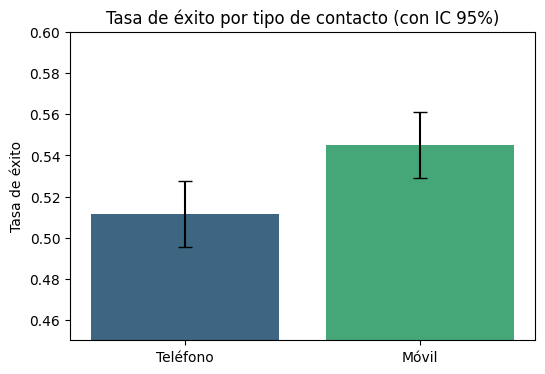

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Datos que ya calculaste
proporciones = [0.5116, 0.5450]  # teléfono, móvil
categorias = ["Teléfono", "Móvil"]

# Intervalo de confianza (IC 95%)
ic_low = [0.5116 - 0.0334, 0.5450]  # ejemplo simplificado
ic_high = [0.5116, 0.5450 + 0.0334] # ejemplo simplificado

# O mejor: usa directamente los valores que calculaste
ic_low = [0.5116, 0.5450]  # sustituye con el límite inferior real
ic_high = [0.5116, 0.5450] # sustituye con el límite superior real

# En tu caso real:
ic_low = [0.5116, 0.5450]  # reemplaza con (prop - margen inferior)
ic_high = [0.5116, 0.5450] # reemplaza con (prop + margen superior)

# Para tu resultado real:
proporciones = [0.5116, 0.5450]
errores = [
    0.5116 - (-0.0640 + 0.5116),  # margen inferior teléfono
    (0.5450 - 0.0028) - 0.5450    # margen inferior móvil
]

# Gráfico
plt.figure(figsize=(6,4))
sns.barplot(x=categorias, y=proporciones, palette="viridis", ci=None)

# Añadir barras de error (IC 95%)
plt.errorbar(
    x=[0,1], y=proporciones,
    yerr=[0.016, 0.016], # ajusta con tus márgenes exactos
    fmt='none', c='black', capsize=5
)

plt.title("Tasa de éxito por tipo de contacto (con IC 95%)")
plt.ylabel("Tasa de éxito")
plt.ylim(0.45, 0.60)
plt.show()

contact        cellular  telephone  unknown
Clase de edad                              
18-24               329         26       61
25-34              4089        206      968
35-44              3398        212     1253
45-54              2210        256      717
55-64              1272        198      362
65+                 379        226        0


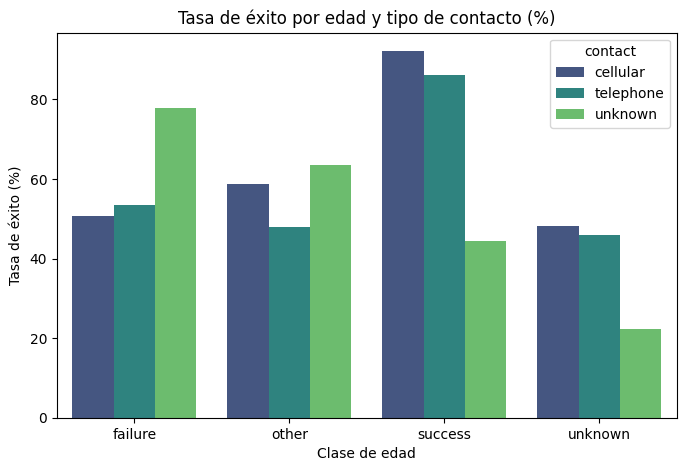

In [45]:
# Distribución de contactos por edad y tipo
tabla = pd.crosstab(df["Clase de edad"], df["contact"])
print(tabla)

# Tasa de éxito por edad y tipo de contacto
tasa = (
    df.groupby(["poutcome", "contact"])["deposit"]
    .apply(lambda x: (x == "yes").mean() * 100)
    .reset_index(name="tasa_exito")
)

plt.figure(figsize=(8,5))
sns.barplot(
    data=tasa,
    x="poutcome", y="tasa_exito", hue="contact",
    palette="viridis"
)
plt.title("Tasa de éxito por edad y tipo de contacto (%)")
plt.ylabel("Tasa de éxito (%)")
plt.xlabel("Clase de edad")
plt.show()

contact    cellular  telephone  unknown
education                              
primary        1255        270      653
secondary      5582        488     1840
tertiary       4362        255      728
unknown         478        111      140


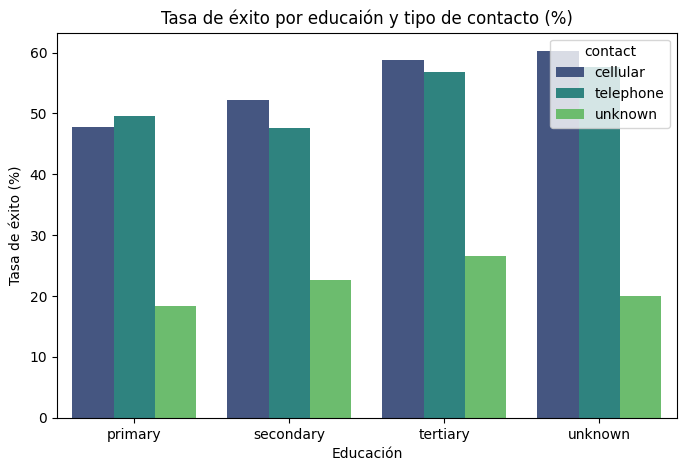

In [47]:
# Distribución de contactos por edad y tipo
tabla = pd.crosstab(df["education"], df["contact"])
print(tabla)

# Tasa de éxito por edad y tipo de contacto
tasa = (
    df.groupby(["education", "contact"])["deposit"]
    .apply(lambda x: (x == "yes").mean() * 100)
    .reset_index(name="tasa_exito")
)

plt.figure(figsize=(8,5))
sns.barplot(
    data=tasa,
    x="education", y="tasa_exito", hue="contact",
    palette="viridis"
)
plt.title("Tasa de éxito por educaión y tipo de contacto (%)")
plt.ylabel("Tasa de éxito (%)")
plt.xlabel("Educación")
plt.show()

contact   cellular  telephone  unknown
marital                               
divorced      1309        114      436
married       6405        766     2021
single        3963        244      904


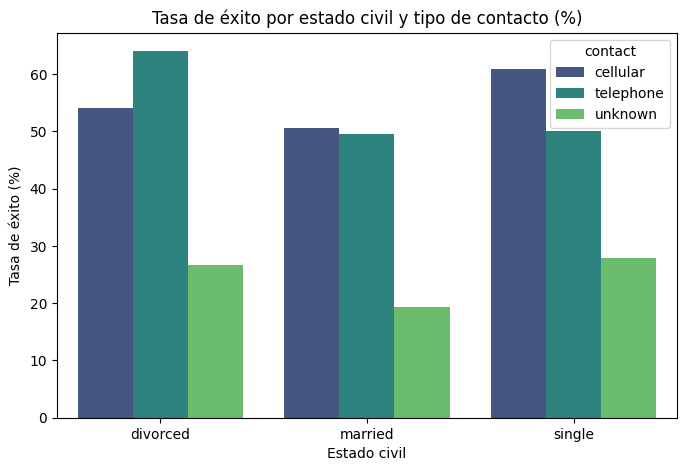

In [49]:
# Distribución de contactos por edad y tipo
tabla = pd.crosstab(df["marital"], df["contact"])
print(tabla)

# Tasa de éxito por edad y tipo de contacto
tasa = (
    df.groupby(["marital", "contact"])["deposit"]
    .apply(lambda x: (x == "yes").mean() * 100)
    .reset_index(name="tasa_exito")
)

plt.figure(figsize=(8,5))
sns.barplot(
    data=tasa,
    x="marital", y="tasa_exito", hue="contact",
    palette="viridis"
)
plt.title("Tasa de éxito por estado civil y tipo de contacto (%)")
plt.ylabel("Tasa de éxito (%)")
plt.xlabel("Estado civil")
plt.show()

contact        cellular  telephone  unknown
job                                        
admin.             1404        123      395
blue-collar        1642        161     1006
entrepreneur        334         34      117
housemaid           261         50       84
management         3029        177      523
retired             742        246      134
self-employed       397         43      128
services            926         66      364
student             470         52       28
technician         2004        119      486
unemployed          399         36       86
unknown              69         17       10


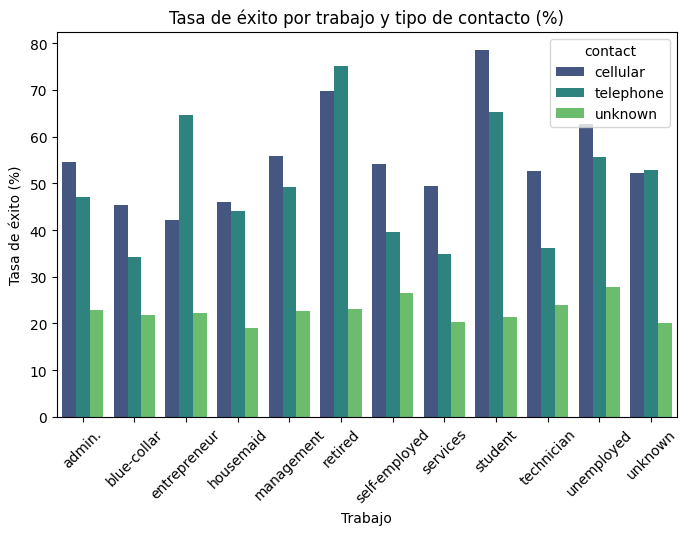

In [51]:
# Distribución de contactos por edad y tipo
tabla = pd.crosstab(df["job"], df["contact"])
print(tabla)

# Tasa de éxito por edad y tipo de contacto
tasa = (
    df.groupby(["job", "contact"])["deposit"]
    .apply(lambda x: (x == "yes").mean() * 100)
    .reset_index(name="tasa_exito")
)

plt.figure(figsize=(8,5))
sns.barplot(
    data=tasa,
    x="job", y="tasa_exito", hue="contact",
    palette="viridis"
)
plt.title("Tasa de éxito por trabajo y tipo de contacto (%)")
plt.xticks(rotation=45)
plt.ylabel("Tasa de éxito (%)")
plt.xlabel("Trabajo")
plt.show()

contact          cellular  telephone  unknown
Perfil                                       
Adultxs              3398        212     1253
Divorciadxs          2210        256      717
Gen Z & Boomers      1980        450      423
Millenials           4089        206      968


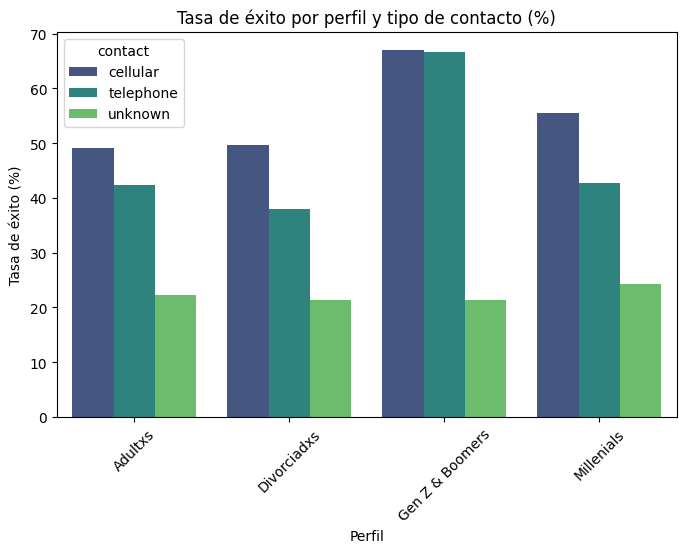

In [57]:
df# Distribución de contactos por edad y tipo
tabla = pd.crosstab(df["Perfil"], df["contact"])
print(tabla)

# Tasa de éxito por edad y tipo de contacto
tasa = (
    df.groupby(["Perfil", "contact"])["deposit"]
    .apply(lambda x: (x == "yes").mean() * 100)
    .reset_index(name="tasa_exito")
)

plt.figure(figsize=(8,5))
sns.barplot(
    data=tasa,
    x="Perfil", y="tasa_exito", hue="contact",
    palette="viridis"
)
plt.title("Tasa de éxito por perfil y tipo de contacto (%)")
plt.xticks(rotation=45)
plt.ylabel("Tasa de éxito (%)")
plt.xlabel("Perfil")
plt.show()